In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax
jax.config.update("jax_enable_x64", True)
sys.path.append('../synax/')

import synax
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

2024-07-04 19:28:58.429103: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


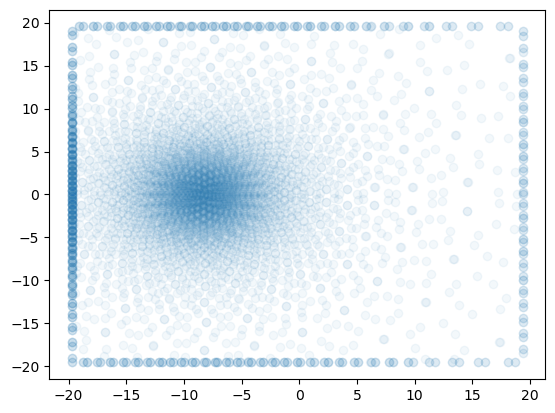

In [3]:
nside = 64
obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi,num_int_points=512))
n_pixs = np.arange(0,12*nside**2)
theta,phi = hp.pix2ang(nside,n_pixs)
poss,dls,nhats = obtain_vmap(theta,phi)
nhats.shape
plt.scatter(poss[::10,0,500],poss[::10,1,500],alpha=0.05)

In [4]:
xs,step = jnp.linspace(-20,20,256,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,256,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,64,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

(256, 256, 64)

## read thermal electrons

In [5]:
dtype = np.float64  # 64-bit floating point
nx,ny,nz = 256,256,64
# Read the binary file
tereg = np.fromfile('../../SyncEmiss/tereg.bin', dtype=dtype).reshape((256,256,64))#.reshape((64,4,64,4,16,4)).mean(axis = (1,3,5))
#ternd = np.fromfile('../../SyncEmiss/ternd.bin', dtype=dtype).reshape((256,256,64))*0#.reshape((64,4,64,4,16,4)).mean(axis = (1,3,5))

breg = np.fromfile('../../SyncEmiss/breg.bin', dtype=dtype).reshape((256,256,64,3))#.reshape((64,4,64,4,16,4,3)).mean(axis = (1,3,5))
brnd = np.fromfile('../../SyncEmiss/brnd.bin', dtype=dtype).reshape((256,256,64,3))#.reshape((64,4,64,4,16,4,3)).mean(axis = (1,3,5))

B_field = jnp.ones_like(breg)*6e-6*jnp.array([1,0,0])

#B_field = jnp.array(breg+brnd)

#interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,B_field[...,0],method='linear',extrap=True))
#Bx_interp = interp_3d(poss)

#interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,B_field[...,1],method='linear',extrap=True))
#By_interp = interp_3d(poss)

#interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,B_field[...,2],method='linear',extrap=True))
#Bz_interp = interp_3d(poss)

interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,B_field,method='linear',extrap=True))
B_field_interp = interp_3d(poss)

TE_field = tereg#+ternd
TE_field = jnp.ones_like(TE_field)*0.01
interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,TE_field,method='linear',extrap=True))
TE_field_interp = interp_3d(poss)
#TE_field = jnp.ones_like(TE_field)*0.01

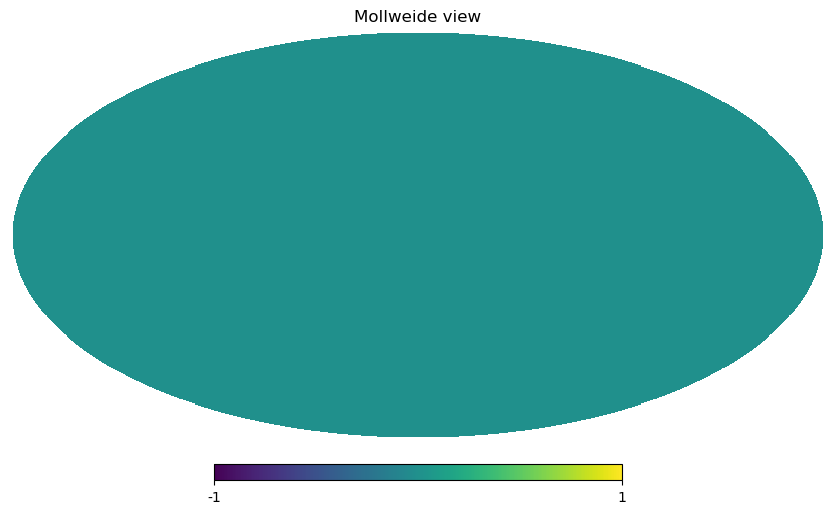

In [6]:
hp.mollview(B_field_interp[:,200,2])

## Calc faraday depth

In [7]:
#const
q_converter = 1/(4*np.pi*const.epsilon_0)**0.5

B_converter = (4*np.pi/const.mu_0)**0.5

freq_irrelavent_const = (const.e*q_converter)**3/(const.electron_mass**2*const.speed_of_light**4)/(2*np.pi)*1e6*1e-4*B_converter*1e19*3.08 # moves 1/cm^3 = 1e6 1/m^3 1 gauss = 1e-4 tesla 1 kpc = 3.08e19 m here.

freq_irrelavent_const

810407283.1937842

In [8]:
B_los = -1*((nhats[:,jnp.newaxis,:]*B_field_interp)).sum(axis=-1)

In [9]:
phis = freq_irrelavent_const*TE_field_interp*B_los
#plt.imshow(phis[:,:,32])
#plt.colorbar()

## Do the integration

In [10]:



sinb = nhats[...,2]
cosb = jnp.sqrt(1-sinb**2)
cosl = nhats[...,0]/cosb
sinl = nhats[...,1]/cosb

Bz = B_field_interp[...,2]
By = B_field_interp[...,1]
Bx = B_field_interp[...,0]
tanchi0 = (Bz*cosb[:,jnp.newaxis]-sinb[:,jnp.newaxis]*(cosl[:,jnp.newaxis]*Bx+By*sinl[:,jnp.newaxis]))/(Bx*sinl[:,jnp.newaxis]-By*cosl[:,jnp.newaxis])
chi0 = jnp.arctan(tanchi0)
#chi0 = chi0.at[chi0<0].set(chi0[chi0<0]+jnp.pi)

#interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,chi0,method='linear',extrap=True))

#chi0_interp = interp_3d(poss)
#plt.imshow(nhats[:,:,32,1])
#plt.colorbar()

In [11]:
%%time

phi_int = jnp.cumsum(phis,axis=1)*dls[:,jnp.newaxis]

CPU times: user 42.6 ms, sys: 657 µs, total: 43.3 ms
Wall time: 66.5 ms


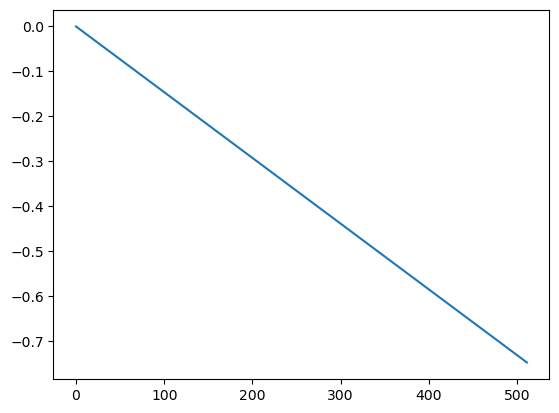

In [12]:
freq = 2.4
fd = phi_int*const.c**2/(freq**2*1e18)
fd_q = jnp.cos(2*fd+2*chi0)
fd_u = jnp.sin(2*fd+2*chi0)
plt.plot(fd[1000])


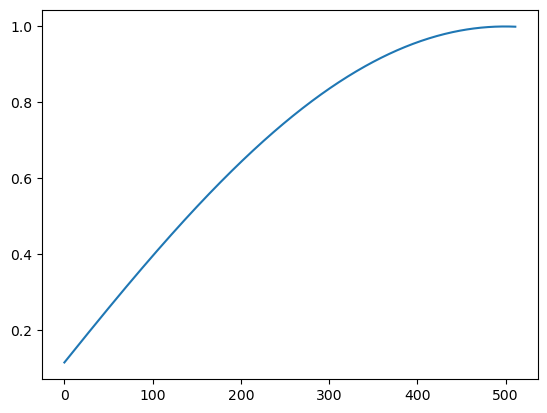

In [13]:
plt.plot(fd_q[1000])

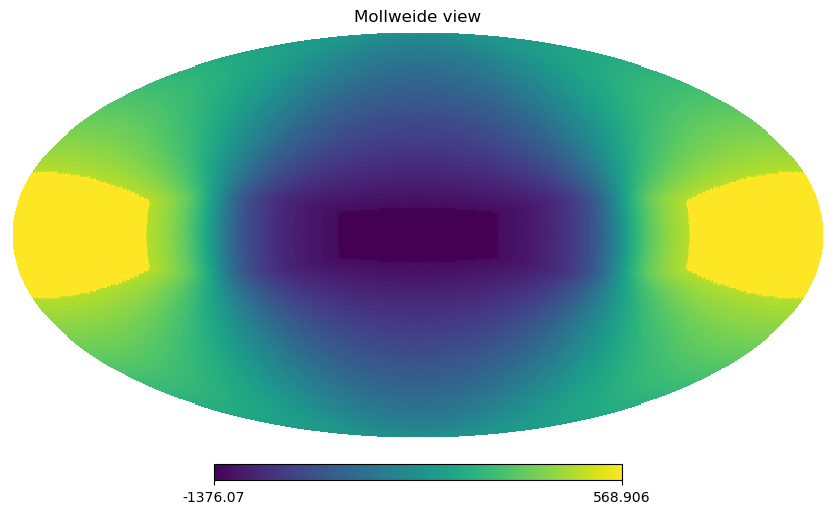

In [14]:
hp.mollview(phi_int[:,-1],norm='hist')

## calc p emissivity

In [15]:
B_field_square = (B_field_interp**2).sum(axis=-1)

B_trans = (B_field_square-B_los**2)**0.5

In [16]:
C_earth = synax.C_page(-8.3,0,0.006)
#C_field = synax.C_page_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))*6.4e1/C_earth
C_field = synax.C_uni_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))
C_field = C_field.reshape((nx,ny,nz))*4.013285414950239e1

interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,C_field,method='linear',extrap=True))
C_field_interp = interp_3d(poss)

In [17]:
emiss = synax.sync_emiss_P(freq,B_trans,C_field_interp,spectral_index=3.)


In [18]:
%%time
Sync_Q_int = (emiss*fd_q).sum(axis=-1)*dls
Sync_U_int = (emiss*fd_u).sum(axis=-1)*dls

CPU times: user 32.6 ms, sys: 4.21 ms, total: 36.8 ms
Wall time: 64.6 ms


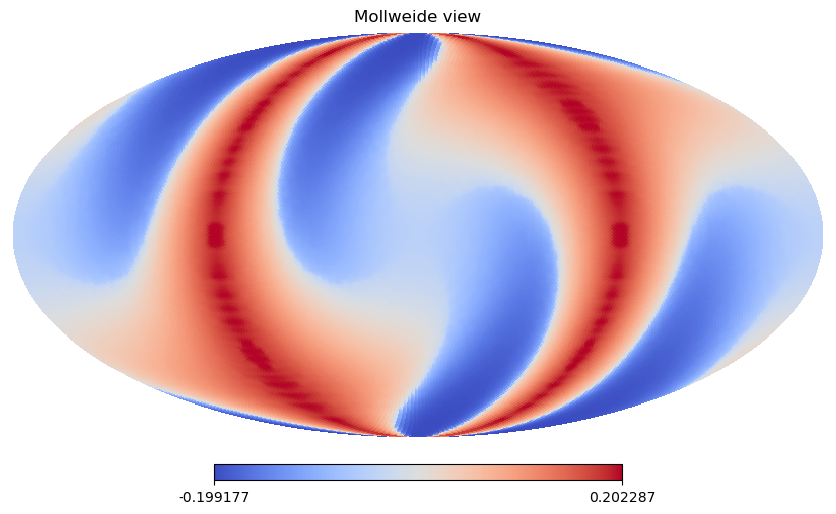

In [19]:
hp.mollview(Sync_Q_int,norm='hist',cmap='coolwarm')

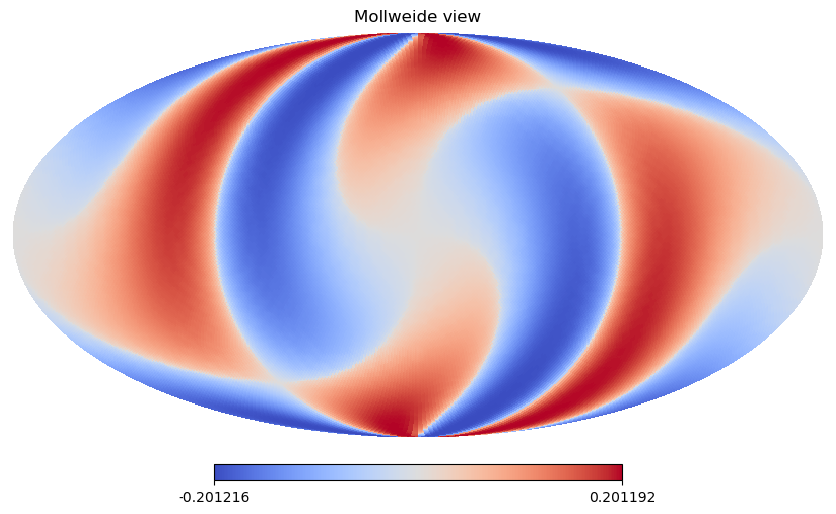

In [20]:
hp.mollview(Sync_U_int,norm='hist',cmap='coolwarm')